In [3]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, json
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor

In [4]:
# Load Data
sales = pd.read_csv("data/sales_train.csv")
items = pd.read_csv("data/items.csv")
shops = pd.read_csv("data/shops.csv")
cats  = pd.read_csv("data/item_categories.csv")

In [5]:
# Clean Data
sales["date"] = pd.to_datetime(sales["date"], format="%d.%m.%Y", errors="coerce")
sales["item_cnt_day"] = sales["item_cnt_day"].clip(lower=-3, upper=sales["item_cnt_day"].quantile(0.999))
sales["item_price"]   = sales["item_price"].clip(lower=0,  upper=sales["item_price"].quantile(0.999))


In [6]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [7]:
# Aggregate daily → monthly per (shop_id, item_id, date_block_num)
monthly = (sales.groupby(["date_block_num","shop_id","item_id"])
           .agg(item_cnt_month=("item_cnt_day","sum"),
                avg_item_price=("item_price","mean")).reset_index())

In [8]:
monthly.head()

,date_block_num,shop_id,item_id,item_cnt_month,avg_item_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5


In [9]:
# Enrich
monthly = monthly.merge(items[["item_id","item_category_id"]], on="item_id", how="left")
monthly = monthly.merge(cats.rename(columns={"item_category_name":"category_name"}), on="item_category_id", how="left")
monthly = monthly.merge(shops.rename(columns={"shop_name":"shop_name"}), on="shop_id", how="left")

In [10]:
monthly.head()

,date_block_num,shop_id,item_id,item_cnt_month,avg_item_price,item_category_id,category_name,shop_name
0,0,0,32,6.0,221.0,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
1,0,0,33,3.0,347.0,37,Кино - Blu-Ray,"!Якутск Орджоникидзе, 56 фран"
2,0,0,35,1.0,247.0,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
3,0,0,43,1.0,221.0,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
4,0,0,51,2.0,128.5,57,Музыка - MP3,"!Якутск Орджоникидзе, 56 фран"


In [11]:
# Calendar & popularity features
monthly["month"] = monthly["date_block_num"] % 12
monthly["quarter"] = (monthly["month"] // 3) + 1
shop_avg = monthly.groupby(["date_block_num","shop_id"])["item_cnt_month"].mean().rename("shop_avg_cnt")
item_avg = monthly.groupby(["date_block_num","item_id"])["item_cnt_month"].mean().rename("item_avg_cnt")
monthly = monthly.merge(shop_avg.reset_index(), on=["date_block_num","shop_id"], how="left")
monthly = monthly.merge(item_avg.reset_index(), on=["date_block_num","item_id"], how="left")

In [12]:
# Lag helpers
def add_lag(df, keys, col, lags):
    df = df.sort_values(keys+["date_block_num"]).copy()
    for L in lags:
        df[f"{col}_lag{L}"] = df.groupby(keys)[col].shift(L)
    return df

monthly = add_lag(monthly, ["shop_id","item_id"], "item_cnt_month", [1,2,3,6])
monthly = add_lag(monthly, ["shop_id","item_id"], "avg_item_price", [1,2,3])

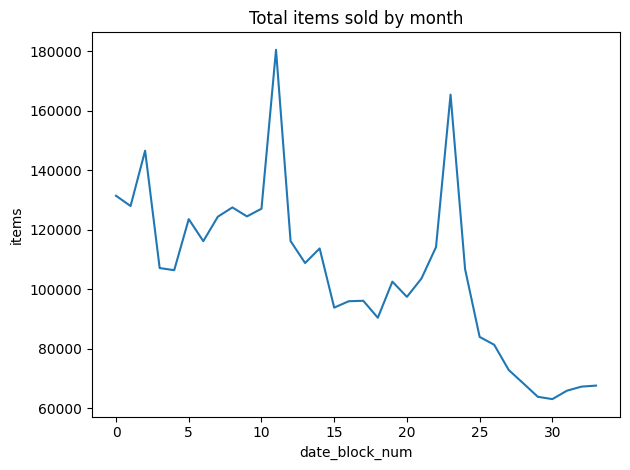

In [13]:
# EDA plots
# Total items by month
monthly.groupby("date_block_num")["item_cnt_month"].sum().plot(kind="line", title="Total items sold by month")
plt.xlabel("date_block_num"); plt.ylabel("items"); plt.tight_layout(); plt.show()

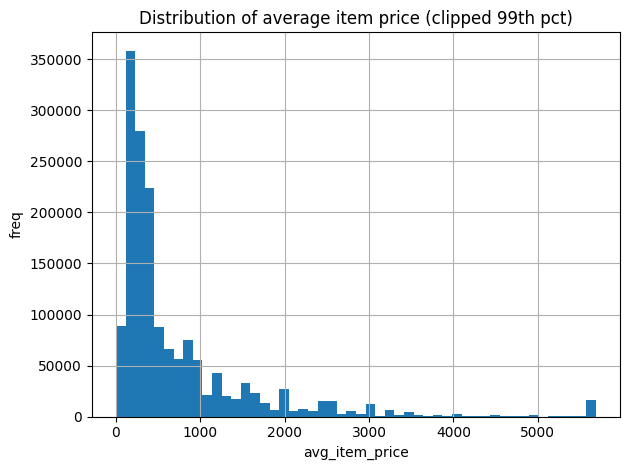

In [14]:
# Price histogram (clipped)
monthly["avg_item_price"].clip(upper=monthly["avg_item_price"].quantile(0.99)).hist(bins=50)
plt.title("Distribution of average item price (clipped 99th pct)"); plt.xlabel("avg_item_price"); plt.ylabel("freq")
plt.tight_layout(); plt.show()

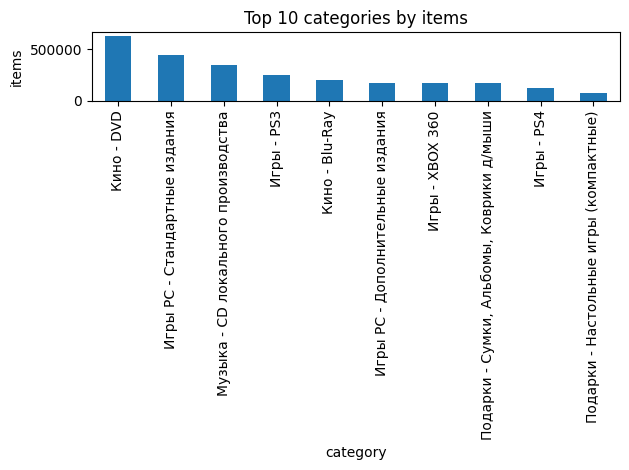

In [15]:
# Top 10 categories by items
monthly.groupby("category_name")["item_cnt_month"].sum().sort_values(ascending=False).head(10).plot(kind="bar", title="Top 10 categories by items")
plt.xlabel("category"); plt.ylabel("items"); plt.tight_layout(); plt.show()

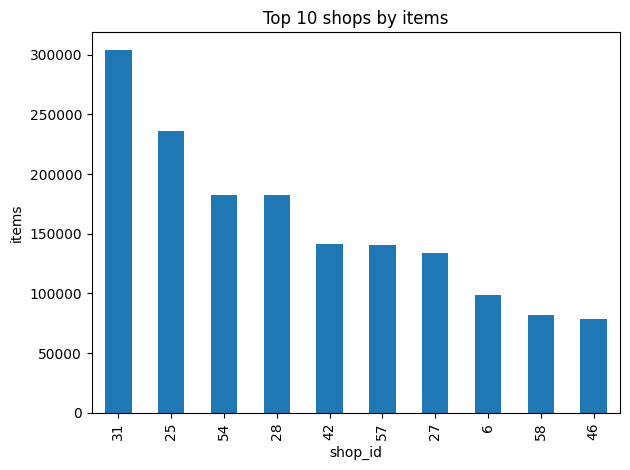

In [16]:
# Top 10 shops by items
monthly.groupby("shop_id")["item_cnt_month"].sum().sort_values(ascending=False).head(10).plot(kind="bar", title="Top 10 shops by items")
plt.xlabel("shop_id"); plt.ylabel("items"); plt.tight_layout(); plt.show()

In [17]:
# Baselines (time-based split)
max_block = int(monthly["date_block_num"].max())
val_block = max_block - 1  # train ≤ T-2, validate on T-1
train = monthly[monthly["date_block_num"] <= val_block-1].copy()
val   = monthly[monthly["date_block_num"] == val_block].copy()


In [18]:
# Seasonal-average baseline
seasonal_key = ["shop_id","item_id","month"]
seasonal_mean = (train.groupby(seasonal_key)["item_cnt_month"].mean().rename("seasonal_mean").reset_index())
vb = val.merge(seasonal_mean, on=seasonal_key, how="left")
item_mean = train.groupby("item_id")["item_cnt_month"].mean().rename("item_mean").reset_index()
vb = vb.merge(item_mean, on="item_id", how="left")
global_mean = float(train["item_cnt_month"].mean())
vb["pred_seasonal"] = vb["seasonal_mean"].fillna(vb["item_mean"]).fillna(global_mean)
vb["y"] = vb["item_cnt_month"]

MAE = np.mean(np.abs(vb["y"]-vb["pred_seasonal"]))
RMSE = np.sqrt(np.mean((vb["y"]-vb["pred_seasonal"])**2))
print({"seasonal_MAE": float(MAE), "seasonal_RMSE": float(RMSE), "val_block": val_block})

{'seasonal_MAE': 1.9981294491545505, 'seasonal_RMSE': 8.14915375267955, 'val_block': 32}


In [19]:
# RandomForest baseline
model_df = monthly.dropna(subset=["item_cnt_month_lag1","item_cnt_month_lag2","item_cnt_month_lag3","item_cnt_month_lag6",
                                  "avg_item_price_lag1","avg_item_price_lag2","avg_item_price_lag3"]).copy()
rf_train = model_df[model_df["date_block_num"] <= val_block-1]
rf_val   = model_df[model_df["date_block_num"] == val_block]

features = ["month","quarter","shop_avg_cnt","item_avg_cnt",
            "item_cnt_month_lag1","item_cnt_month_lag2","item_cnt_month_lag3","item_cnt_month_lag6",
            "avg_item_price_lag1","avg_item_price_lag2","avg_item_price_lag3",
            "shop_id","item_id","item_category_id"]

Xtr, ytr = rf_train[features].fillna(0), rf_train["item_cnt_month"].values
Xva, yva = rf_val[features].fillna(0), rf_val["item_cnt_month"].values

rf = RandomForestRegressor(n_estimators=120, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(Xtr, ytr)
pred_rf = rf.predict(Xva)
mae_rf = np.mean(np.abs(yva-pred_rf))
rmse_rf = np.sqrt(np.mean((yva-pred_rf)**2))
print({"rf_MAE": float(mae_rf), "rf_RMSE": float(rmse_rf)})

{'rf_MAE': 0.7555890717146745, 'rf_RMSE': 1.9506349700131576}


In [24]:
# Rough elasticities

MIN_MONTHS = 6

catm = (monthly.groupby(["item_category_id","date_block_num"], as_index=False)
        .agg(item_cnt_month=("item_cnt_month","sum"),
             avg_item_price=("avg_item_price","mean")))

catm = catm[(catm["avg_item_price"] > 0) & (catm["item_cnt_month"] >= 0)].copy()
catm["log_cnt"] = np.log1p(catm["item_cnt_month"]).astype(np.float32)
catm["log_price"] = np.log(catm["avg_item_price"]).astype(np.float32)

rows = []
name_map = cats.set_index("item_category_id")["item_category_name"].to_dict()

for cid, g in catm.groupby("item_category_id", sort=False):
    if g["date_block_num"].nunique() < MIN_MONTHS or g["log_price"].std() == 0:
        continue
    x = g["log_price"].to_numpy(dtype=np.float32, copy=False)
    y = g["log_cnt"].to_numpy(dtype=np.float32, copy=False)
    b1, b0 = np.polyfit(x, y, deg=1)
    rows.append({
        "item_category_id": int(cid),
        "item_category_name": name_map.get(int(cid), f"cat_{int(cid)}"),
        "n_months": int(g["date_block_num"].nunique()),
        "price_elasticity": float(b1)
    })

elasticity = pd.DataFrame(rows).sort_values("price_elasticity").reset_index(drop=True)


In [25]:
# Scenario calculator
def revenue_change_pct(elasticity, dpp):
    return dpp + elasticity * dpp

scenarios = []
for _, r in elasticity.head(8).iterrows():  # most price-sensitive
    for pct in (-0.05, 0.05):
        scenarios.append({
            "category": r["item_category_name"],
            "elasticity": r["price_elasticity"],
            "price_change_pct": pct,
            "approx_revenue_change_pct": revenue_change_pct(r["price_elasticity"], pct)
        })
pd.DataFrame(scenarios)

,category,elasticity,price_change_pct,approx_revenue_change_pct
0,Книги - Аудиокниги,-12.198892,-0.05,0.559945
1,Книги - Аудиокниги,-12.198892,0.05,-0.559945
2,Музыка - MP3,-11.508594,-0.05,0.525430
3,Музыка - MP3,-11.508594,0.05,-0.525430
4,Книги - Аудиокниги 1С,-10.550286,-0.05,0.477514
5,Книги - Аудиокниги 1С,-10.550286,0.05,-0.477514
6,Игровые консоли - PS4,-8.134826,-0.05,0.356741
7,Игровые консоли - PS4,-8.134826,0.05,-0.356741
8,Кино - DVD,-7.201555,-0.05,0.310078
9,Кино - DVD,-7.201555,0.05,-0.310078
